# Building Bonsai BDT for Online Triggering

* Step 1 : Pull out features for classification.  These include energy deposit on wire, energy deposit of left neighbour, energy deposit of right neighbour, and layer id (radial distance).
* Step 2 : Bin these features into 11 bins, 10 with deposits, one with no deposits
* Step 3 : Train the GBDT to recognize hit wires based on these binned energy features and layer_id
* Step 4 : Build a look up table of dimention [11,11,11,18], so it has an entry for each possible combination of features
* Step 5 : Fill the table with the output of the wire GBDT
* Step 6 : Define layer features based on this output
* Step 7 : Pass layer features through event GBDT
* Step 8 : Determine signal or background based on this output

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CDCHits, CTHHits, CyDetHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter, OrderedDict
sys.path.insert(0, '../modules')
%load_ext memory_profiler
from root_numpy import root2array
import scipy.sparse

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run data_tools.ipynb

In [3]:
recbe_wiring_file = "/home/elg112/development/ICEDUST/track_finding_standalone/"+\
                    "track_finding_yandex/data/chanmap_20160814.root"
recbe_positions = root2array(recbe_wiring_file, selection="isSenseWire == 1 && LayerID > 0 && LayerID < 19", 
                                        branches=["LayerID", "CellID","BoardID",
                                                  "BrdLayID", "BrdLocID","ChanID"])
recbe_positions["LayerID"] = recbe_positions["LayerID"] - 1

In [4]:
def get_occupancy(cdc_sample):
    sig_occ, back_occ, occ = list(), list(), list()
    for event in range(cdc_sample.n_events):
        sig_occ += [len(np.unique(cdc_sample.get_signal_hits(event)[cdc_sample.flat_name]))]
        back_occ += [len(np.unique(cdc_sample.get_background_hits(event)[cdc_sample.flat_name]))]
        occ += [len(np.unique(cdc_sample.get_events(event)[cdc_sample.flat_name]))]  
        
    # print some infor
    avg_n_hits = np.average(cdc_sample.event_to_n_hits)
    avg_occ = np.average(occ)
    print "Sig Occ: {} , Back Occ : {}".format(np.average(sig_occ), np.average(back_occ))
    print "All Occ: {}, {}".format(avg_occ, avg_occ/4482.)
    print "NumHits: {}".format(avg_n_hits)
    print "MinChansMultiHit: {}".format((avg_n_hits - avg_occ)/float(avg_occ))
    
    return sig_occ, back_occ, occ

In [5]:
def get_measurment_and_neighbours(hit_sample, measurement, events=None, digitize=False, bins=None,
                                  **kwargs):
    """
    Get the measurement on the wire and its neighbours in a classification-friendly way
    
    :return: a list of three numpy arrays of measurement 1) on wire, 2) to left, 3) to right
    """
    if digitize:
        return [np.digitize(hit_sample.get_measurement(measurement, 
                                       events, 
                                       shift=i, 
                                       only_hits=True, 
                                       flatten=True, **kwargs), bins=bins) 
                for i in [0,-1,1]]
    else:
        return [hit_sample.get_measurement(measurement, 
                                           events, 
                                           shift=i, 
                                           only_hits=True, 
                                           flatten=True, **kwargs) 
                    for i in [0,-1,1]] 

In [6]:
def remove_coincidence(sample):
    # Get the energy deposition summed
    all_events = np.arange(sample.cdc.n_events)
    edep_sparse = scipy.sparse.lil_matrix((sample.cdc.n_events, sample.cdc.geom.n_points))
    for evt in all_events:
        meas = sample.cdc.get_events(evt)[sample.cdc.edep_name]
        # Get the wire_ids of the hit data
        wire_ids = sample.cdc.get_hit_vols(evt, unique=False)
        edep_sparse[evt,wire_ids] += meas
    # Sort by hit type name to keep signal hits preferentiably
    sample.cdc.sort_hits(sample.cdc.hit_type_name, ascending=False, reset_index=True)
    hit_indexes = sample.cdc.get_measurement(sample.cdc.hits_index_name, all_events)
    # Remove the hits that are not needed
    sample.cdc.trim_hits(sample.cdc.hits_index_name, values=hit_indexes)
    all_events = np.arange(sample.cdc.n_events)
    # Get the wire_ids and event_ids of the hit data
    wire_ids = sample.cdc.get_hit_vols(all_events, unique=False)
    # Map the evnt_ids to the minimal continous set
    evnt_ids = np.repeat(np.arange(all_events.size),
                         sample.cdc.event_to_n_hits[all_events])
    # Force the new edep values onto the sample
    hit_indexes = sample.cdc.get_measurement(sample.cdc.hits_index_name, all_events).astype(int)
    sample.cdc.data[sample.cdc.edep_name][hit_indexes] = edep_sparse[evnt_ids, wire_ids].toarray()

# Signal Data

In [7]:
file_base = "/home/elg112/development/ICEDUST/track_finding_standalone/"\
            "track_finding_yandex/data/"
signal_files  = ["oa_xx_xxx_09100000-0000_opgjz6dop7ho_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09200000-0000_bxszqgjrri2n_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09400000-0000_7i52rtj3sz5v_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09600000-0000_xjij4zcypjul_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09800000-0000_b72ef5hzppor_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09900000-0000_orbwudhvihxn_user-TrkTree_000_signal-label.root"]

signal_files = ["oa_xx_xxx_09000000-0000_pdevedxn64ot_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09100000-0000_skzt2l7sdqvx_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09200000-0000_x67rltrbhc3n_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09300000-0000_seae7w5z6fvt_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09400000-0000_o774i4trtmim_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09500000-0000_ufkycd74hb4i_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09600000-0000_arxgz3idch3j_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09700000-0000_5xz67bjkzokx_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09800000-0000_jrdukg5g2ivh_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09900000-0000_kgij2afd5rtp_user-TrkTree_000_500signal-label.root"]

signal_files = ["oa_xx_xxx_09000000-0000_qs4c2zivfkyl_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09100000-0000_k6i42km533k7_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09200000-0000_uuu3dtsod77t_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09300000-0000_2s4hlrntpcyh_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09400000-0000_vrw7y5jhefms_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09500000-0000_2xxlflqodbqq_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09600000-0000_ak6psvrdnn4v_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09700000-0000_bipfrfikeaqy_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09800000-0000_5w5tj34s5elw_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09900000-0000_diro4pagpbtt_user-TrkTree_000_700signal-label.root"]


back_files = ["batch_2_TrkTree_2500.root",
              "batch_3_TrkTree_2536.root",
              "batch_4_TrkTree_5250.root"]

signal_files = [ file_base + file_name for file_name in signal_files]
back_files   = [ file_base + file_name for file_name in back_files]

In [8]:
import root_numpy

In [9]:
pprint(root_numpy.list_branches(signal_files[0], treename="CTHHitTree"))

['CTHHit.fGoodTrack',
 'CTHHit.fGoodTrig',
 'CTHHit.fModule',
 'CTHHit.fCounter',
 'CTHHit.fIsSc',
 'CTHHit.fIsLG',
 'CTHHit.fNContrib',
 'CTHHit.fTrack.fTrackID',
 'CTHHit.fTrack.fParentTrackID',
 'CTHHit.fTrack.fPID',
 'CTHHit.fTrack.fTags.fTagMaskPersisted',
 'CTHHit.fTrack.fTagsAsParent.fTagMaskPersisted',
 'CTHHit.fTrack.fTagsAsDaughter.fTagMaskPersisted',
 'CTHHit.fTrack.fStartMomentum.fX',
 'CTHHit.fTrack.fStartMomentum.fY',
 'CTHHit.fTrack.fStartMomentum.fZ',
 'CTHHit.fTrack.fStopMomentum.fX',
 'CTHHit.fTrack.fStopMomentum.fY',
 'CTHHit.fTrack.fStopMomentum.fZ',
 'CTHHit.fTrack.fStartPosGlobal.fP.fX',
 'CTHHit.fTrack.fStartPosGlobal.fP.fY',
 'CTHHit.fTrack.fStartPosGlobal.fP.fZ',
 'CTHHit.fTrack.fStartPosGlobal.fE',
 'CTHHit.fTrack.fStopPosGlobal.fP.fX',
 'CTHHit.fTrack.fStopPosGlobal.fP.fY',
 'CTHHit.fTrack.fStopPosGlobal.fP.fZ',
 'CTHHit.fTrack.fStopPosGlobal.fE',
 'CTHHit.fMCPos.fP.fX',
 'CTHHit.fMCPos.fP.fY',
 'CTHHit.fMCPos.fP.fZ',
 'CTHHit.fMCPos.fE',
 'CTHHit.fCharge',
 

In [10]:
def import_sample(this_signal, this_background, these_cuts=None, these_branches=None):
    back_hits = import_file(this_background, signal=False, 
                             use_cuts=these_cuts, branches=these_branches)
    sig_hits = import_file(this_signal, signal=True,
                           use_cuts=these_cuts, branches=these_branches)
    sig_hits.keep_common_events()
    back_hits.keep_common_events()
    events_to_keep = np.random.permutation(np.arange(0, sig_hits.n_events))[:back_hits.n_events]
    event_numbers = np.unique(sig_hits.cdc.get_events()[sig_hits.cdc.key_name])[events_to_keep]
    sig_hits.cdc.trim_events(event_numbers) 
    sig_hits.cth.trim_events(event_numbers) 
    print "CTH Sig Events {} ".format(sig_hits.cth.n_events)
    print "CTH Sig Events {} ".format(back_hits.cth.n_events)
    print "CDC Sig Events {} ".format(sig_hits.cth.n_events)
    print "CDC Sig Events {} ".format(back_hits.cth.n_events)
    back_hits.cdc.add_hits(sig_hits.cdc.data)
    back_hits.cth.add_hits(sig_hits.cth.data)
    return back_hits

In [11]:
these_branches = {}
these_branches["CDC"] = ["MCPos.fP.fX", "MCPos.fP.fY", "MCPos.fP.fZ"]
these_branches["CTH"] = ["MCPos.fP.fX", "MCPos.fP.fY", "MCPos.fP.fZ"]

In [12]:
train = data_import_sample(signal_files[0], back_files[0], 
                      these_cuts=["Trig","Track","700"],
                      branches=these_branches)
test = data_import_sample(signal_files[1], back_files[1], 
                      these_cuts=["Trig","Track","700"],
                      branches=these_branches)

Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': 'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': 'CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Trimming Signal Events
CTH Sig Events 2491 
CTH Back Events 2491 
CDC Sig Events 2491 
CDC Back Events 2491 
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': [

In [13]:
train.cth.set_trigger_time()
test.cth.set_trigger_time()

In [14]:
remove_coincidence(train)
remove_coincidence(test)

In [15]:
train.print_branches()

CTH Branches:
Branches available are:
CTHHit.fMCPos.fP.fX
CTHHit.fMCPos.fP.fY
CTHHit.fMCPos.fP.fZ
CTHHit.fIsSig
CTHHit.fEventNumber
CTHHit.fhits_index
CTHHit.fevent_index
CTHHit.fTrigTime
CTHHit.fvol_id
CTHHit.fCharge
CTHHit.fMCPos.fE
CDC Branches:
Branches available are:
CDCHit.fMCPos.fP.fX
CDCHit.fMCPos.fP.fY
CDCHit.fMCPos.fP.fZ
CDCHit.fIsSig
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


## Define Training Sample For Track Finding

In [16]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [17]:
# Split up the data first
from sklearn.cross_validation import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = range(train.cdc.n_events)
sample_1, sample_2 = train_test_split(rest, train_size=0.90, test_size=0.10, random_state=seed)

# Get event masks
evt_samp       = [ sample_1, sample_2 ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

In [18]:
# Get samples
# TODO clean me up a lot
test_rest = range(test.cdc.n_events)
test_sample_1, test_sample_2 = train_test_split(rest, train_size=0.90, test_size=0.10, random_state=seed)

# Get event masks
test_evt_samp       = [ test_sample_1, test_sample_2 ]
test_evt_samp_masks, test_hit_masks = reset_masks(test_evt_samp, test.cdc)

# Look at features

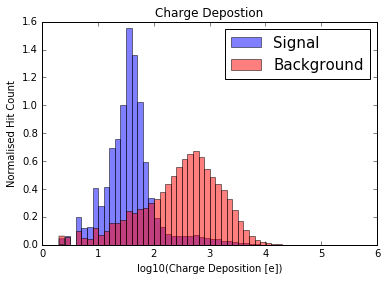

In [19]:
bins_for_plots = 50
plot_feature( np.log10(train.cdc.get_signal_hits()[train.cdc.edep_name] + 1), 
              np.log10(train.cdc.get_background_hits()[train.cdc.edep_name] + 1), 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=bins_for_plots)
show()

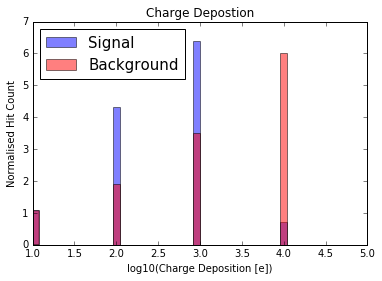

[0, 1.0, 1.5, 2.0, 2.5]
[  10.    31.5  100.   315. ]


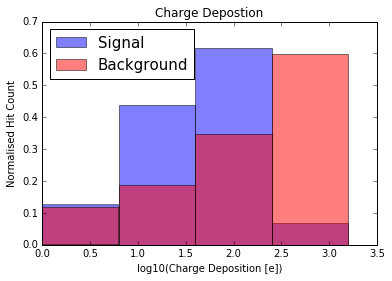

In [20]:
bins_for_plots = 50
global_bins = [0,1.0,1.5,2.0,2.5]
plot_feature( np.digitize(np.log10(train.cdc.get_signal_hits()[train.cdc.edep_name] + 1), 
                          bins=global_bins),
              np.digitize(np.log10(train.cdc.get_background_hits()[train.cdc.edep_name] + 1), 
                          bins=global_bins),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=bins_for_plots)
show()
bins_for_plots = 50
print global_bins
powered_bins = np.array([10, 31.5, 100, 315])
print powered_bins
plot_feature( np.digitize(train.cdc.get_signal_hits()[train.cdc.edep_name], 
                          bins=powered_bins),
              np.digitize(train.cdc.get_background_hits()[train.cdc.edep_name], 
                          bins=powered_bins),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=5)
show()

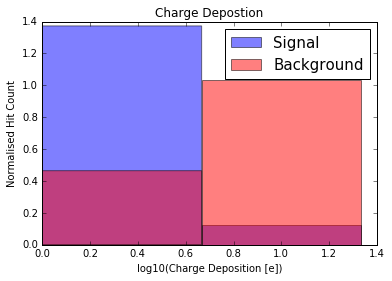

In [21]:
bins_for_plots = 50
plot_feature( np.digitize(np.log10(train.cdc.get_signal_hits()[train.cdc.edep_name] ), 
                          bins=[2,3]),
              np.digitize(np.log10(train.cdc.get_background_hits()[train.cdc.edep_name] ), 
                          bins=[2,3]),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=3)
show()

## Define Wire Features 

In [22]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc
from pandas import DataFrame
from sklearn.metrics import roc_auc_score, roc_curve

In [23]:
# Define Data
energy_feature = "Energy"
binary_energy = energy_feature + "_binary"
binned_energy = energy_feature+ "_binned"
energy_feature = energy_feature + "_unbin"
board_id = "RECBE_id"
board_layer = "RECBE_layer"
layer_id = "Layer_ID"

binary_wire_features = [binary_energy, 
                        binary_energy + "_left",
                        binary_energy + "_right"]
binned_wire_features = [binned_energy, 
                        binned_energy + "_left",
                        binned_energy + "_right"]
unbin_wire_features = [energy_feature, 
                       energy_feature + "_left",
                       energy_feature + "_right"]
all_features = binary_wire_features + \
               binned_wire_features + \
               unbin_wire_features + \
               [board_id, board_layer, layer_id]

In [24]:
factory = ClassifiersFactory()

# Define GBDT over unbinned wire features
binary_energy = SklearnClassifier(GradientBoostingClassifier(n_estimators=100),
                                  features=[energy_feature])
factory.add_classifier('ADC', binary_energy)
# Define GBDT over unbinned wire features
binary_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=binary_wire_features + [board_id])
factory.add_classifier('Binary', binary_neighs)
# Define GBDT over unbinned wire features
binned_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=binned_wire_features + [board_id])
factory.add_classifier('Binned', binned_neighs)
# Define GBDT over unbinned wire features
unbin_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=unbin_wire_features + [layer_id])
factory.add_classifier('Unbinned', unbin_neighs)

In [25]:
print train.cdc.n_hits, train.cdc.n_events
print train.cdc.get_measurement(train.cdc.hit_type_name).shape

1427076 2491
(1427076,)


In [26]:
# Deal with coincidence
train.cdc.sort_hits(train.cdc.hit_type_name, ascending=False, reset_index=True)
print sum(train.cdc.get_measurement(train.cdc.hit_type_name))
train_cdc_flat_id = train.cdc.get_measurement(train.cdc.flat_name, events=evt_samp[0]).astype(int)

199195.0


In [27]:
def get_data_frame(samp, events):
    flat_ids = samp.cdc.get_measurement(samp.cdc.flat_name, events=events).astype(int)
    return DataFrame(np.vstack(
                        get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[100,1000], default=1) +\
                        get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[10, 31.5, 100, 315], 
                                                      default=3) +\
                        get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events) +\
                        [recbe_positions["BoardID" ][flat_ids]] +\
                        [recbe_positions["BrdLayID"][flat_ids]] +\
                        [samp.cdc.geom.get_layers(flat_ids)]).T, columns=all_features)

In [28]:
# Train the classifier
factory.fit(get_data_frame(train, evt_samp[0]),
            train.cdc.get_measurement(train.cdc.hit_type_name, events=evt_samp[0]))

model ADC          was trained in 86.19 seconds
model Binary       was trained in 103.69 seconds
model Binned       was trained in 126.23 seconds
model Unbinned     was trained in 147.23 seconds
Totally spent 463.35 seconds on training


ClassifiersFactory([('ADC',
                     SklearnClassifier(clf=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
                                   max_depth=3, max_features=None, max_leaf_nodes=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100,
                                   presort='auto', random_state=None, subsample=1.0, verbose=0,
                                   warm_start=False),
                              features=['Energy_unbin'])),
                    ('Binary',
                     SklearnClassifier(clf=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
                                   max_depth=3, max_features=None, max_leaf_nodes=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100,
    

In [29]:
# Deal with coincidence
test.cdc.sort_hits(test.cdc.hit_type_name, ascending=False, reset_index=True)
print sum(test.cdc.get_measurement(test.cdc.hit_type_name))
test_cdc_flat_id = test.cdc.get_measurement(test.cdc.flat_name, events=test_evt_samp[0]).astype(int)

199321.0


In [30]:
# Test the classifier
bbdt_diagnostics = \
    factory.test_on(get_data_frame(test, test_evt_samp[0]), 
                    test.cdc.get_measurement(test.cdc.hit_type_name, events=test_evt_samp[0]))

In [49]:
plot_set_font()
figsize(10, 7)
curve_dict = dict()
plot_rocs(test.cdc.get_measurement(test.cdc.hit_type_name, events=test_evt_samp[0]), 
         bbdt_diagnostics.prediction, 
         zoom=True,
         datum_label="Hit")
plt.show()
for key, preds in bbdt_diagnostics.prediction.iteritems():
    print key
    print "  {}".format(roc_auc_score(test.cdc.get_measurement(test.cdc.hit_type_name, 
                                                               events=test_evt_samp[0]), preds[:,1]))
    curve_dict[key] = roc_curve(test.cdc.get_measurement(test.cdc.hit_type_name, events=test_evt_samp[0])
                                , preds[:,1])

AttributeError: 'function' object has no attribute 'cdc'

In [32]:
threshold_dict = {}
for key, curve in curve_dict.iteritems():
    print np.array(curve).shape
    threshold_dict[key] = curve[2][np.argmin( np.abs(curve[1] - 0.80))]
pprint(threshold_dict)

(3, 977)
(3, 1740)
(3, 259)
(3, 64755)
{'ADC': 0.28732508139522317,
 'Binary': 0.31980016750518264,
 'Binned': 0.36787067055599454,
 'Unbinned': 0.43789551672319493}


In [33]:
#train.cdc.data[train.cdc.prefix+pos[2]] = - (train.cdc.data[train.cdc.prefix+pos[2]]/10. - 765)
#train.cdc.data[train.cdc.prefix+pos[1]] = train.cdc.data[train.cdc.prefix+pos[1]]/10.
#train.cdc.data[train.cdc.prefix+pos[0]] = (train.cdc.data[train.cdc.prefix+pos[0]]/10. - 641)
#train.cth.data[train.cth.prefix+pos[2]] = - (train.cth.data[train.cth.prefix+pos[2]]/10. - 765)
#train.cth.data[train.cth.prefix+pos[1]] = train.cth.data[train.cth.prefix+pos[1]]/10.
#train.cth.data[train.cth.prefix+pos[0]] = (train.cth.data[train.cth.prefix+pos[0]]/10. - 641)

In [34]:
pos = list()
pos += ["MCPos.fP.fX"]
pos += ["MCPos.fP.fY"]
pos += ["MCPos.fP.fZ"]

p = dict()
p["cdc"] = dict()
p["cdc"]["x"] =  train.cdc.prefix + pos[2]
p["cdc"]["y"] =  train.cdc.prefix + pos[1]
p["cdc"]["z"] =  train.cdc.prefix + pos[0]
p["cth"] = dict()
p["cth"]["x"] =  train.cth.prefix + pos[2]
p["cth"]["y"] =  train.cth.prefix + pos[1]
p["cth"]["z"] =  train.cth.prefix + pos[0]

data was predicted by ADC          in 0.00 seconds
data was predicted by Binary       in 0.00 seconds
data was predicted by Binned       in 0.00 seconds
data was predicted by Unbinned     in 0.00 seconds
Totally spent 0.02 seconds on prediction


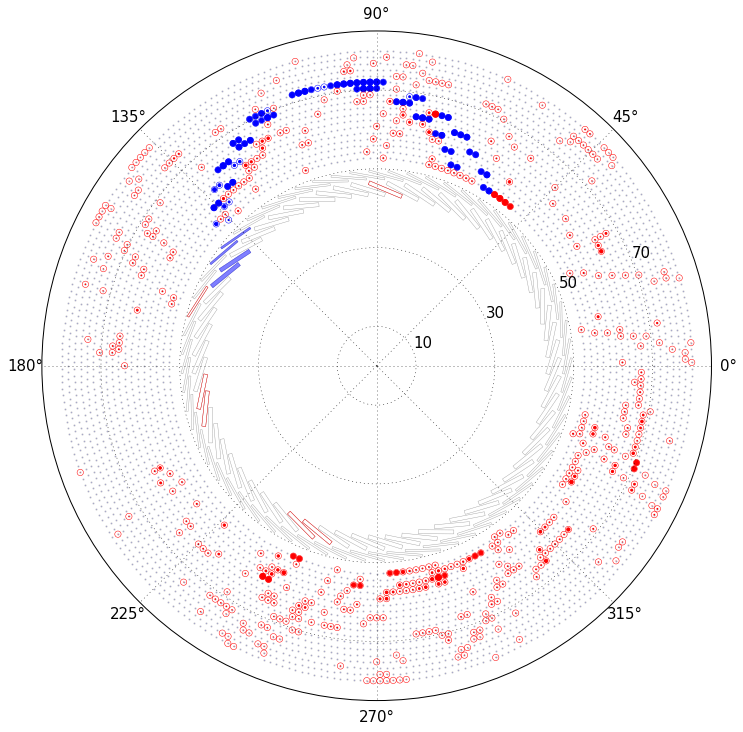

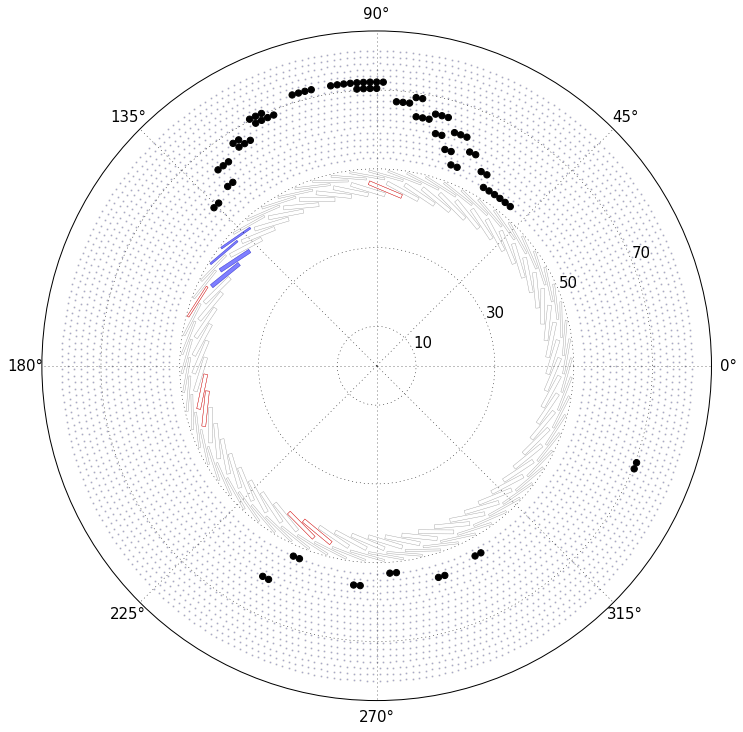

In [35]:
classifier = "Binned"
for evt in range(99,100):
    # Plot the output
    output = np.zeros(4482)
    geom_ids = test.cdc.get_measurement(test.cdc.flat_name, evt).astype(int)
    output[geom_ids] = factory.predict_proba(get_data_frame(test, evt))[classifier][:,1]
    cut = (output >= threshold_dict[classifier])

    for output, outline in zip([output, cut], [True,False]): 
        if not outline:
            plot_output(test.cdc.get_hit_types(evt),
                                      test.cdc.geom, size=output*40,
                        sig_color="Black", bkg_color="Black")
        # Add hit outlines
        if outline:
            plot_output(test.cdc.get_hit_types(evt),
                                      test.cdc.geom, size=output*40)
            plot_add_outlines(test.cdc.get_hit_types(evt), 
                              test.cdc.geom)
        # Add volume outlines
        plot_add_cth_outlines(test.cth.geom)
        # Add the CTH vols with hits
        cth_vol_types = test.cth.get_vol_types(evt)
        plot_add_cth(cth_vol_types, test.cth.get_trig_vector(evt)[0], test.cth.geom)
        cth_hits = test.cth.get_events(evt)
        cdc_hits = test.cdc.get_events(evt)
        #plt.scatter(cth_hits[p["cth"]["x"]], 
        #            cth_hits[p["cth"]["y"]], 
        #            s=1, transform=gca().transData._b)
        #plt.scatter(cdc_hits[p["cdc"]["x"]], 
        #            cdc_hits[p["cdc"]["y"]], 
        #            s=1, color="black",
        #            transform=gca().transData._b)
        plt.show()
    print "====================================================================="

## Import Event Sample

In [36]:
sig_evts = data_import_sample(signal_files[2], back_files[2], 
                              these_cuts=["Trig","Track","700"],
                              branches=these_branches)
bck_evts = data_import_sample(signal_files[2], back_files[2], 
                              these_cuts=["Trig","Track","700"],
                              branches=these_branches)

Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': 'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': 'CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Trimming Background Events
CTH Sig Events 3419 
CTH Back Events 3419 
CDC Sig Events 3419 
CDC Back Events 3419 
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC

In [37]:
bck_evts.cdc.trim_hits(sig_evts.cdc.hit_type_name, values=[False])

In [38]:
sig_evts.cth.set_trigger_time()
bck_evts.cth.set_trigger_time()

In [39]:
remove_coincidence(sig_evts)
remove_coincidence(bck_evts)

### Classify Event Sample

In [40]:
evt_scores = {}
evt_scores["Signal"] = {}
evt_scores["Background"] = {}

In [41]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    for cla in factory.keys():
        print etype, cla
        evt_scores[etype][cla] = np.array([sum(factory[cla].predict_proba(get_data_frame(samp, evt))[:,1])
                                           for evt in range(samp.cdc.n_events)])

Signal ADC
Signal Binary
Signal Binned
Signal Unbinned
Background ADC
Background Binary
Background Binned
Background Unbinned


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd25b505150>,
 <matplotlib.figure.Figure at 0x7fd25b505cd0>)

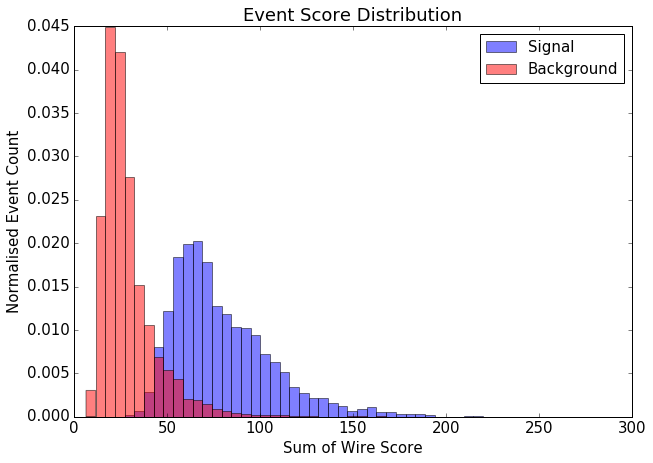

In [42]:
plot_feature( evt_scores["Signal"]["Binned"], 
              evt_scores["Background"]["Binned"], 
              xlabel="Sum of Wire Score", ylabel="Normalised Event Count", 
              xlog=False,
              title="Event Score Distribution", 
              nbins=bins_for_plots)

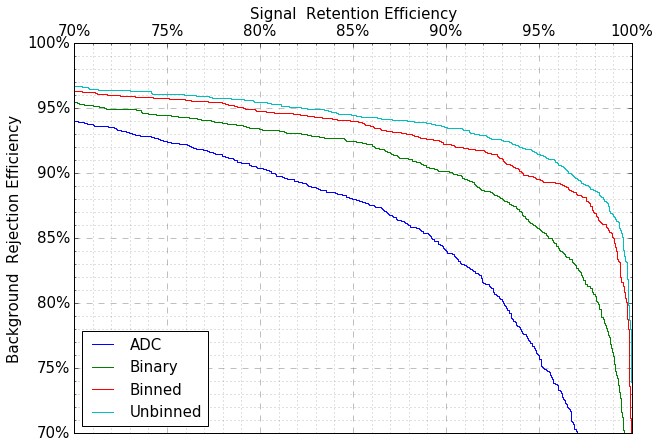

In [50]:
labels = np.zeros(sig_evts.cdc.n_events + bck_evts.cdc.n_events)
labels[:sig_evts.cdc.n_events] = 1
for cla in factory.keys():
    plot_roc_curve(labels, np.append(evt_scores["Signal"][cla],  
                                     evt_scores["Background"][cla]),
                                     label=cla, zoom=True)

### Build Bonsai BDT

In [ ]:
# Check for the binning used in the bonsai BDT
n_bins = len(numpy.unique(new_deps))
n_layers = len(numpy.unique(layer_id))
# Get the GBDT we want
binned_gbdt = factory['Binned Wire Features']

In [ ]:
# Build a numpy array to hold all possible combinations
combinations = numpy.zeros((n_bins*n_bins*n_bins*n_layers,4))
n = 0
print n_layers

# Fill the combinations
for wire in range(n_bins):
    for left in range(n_bins):
        for right in range(n_bins):
            for layer in range(n_layers): 
                combinations[n,:] = wire, left, right, layer
                n += 1
# Make it a data frame with the correct labels
combinations = pandas.DataFrame(data=combinations,columns=['Binned_Deposits','Binned_L_Deposits',\
                                                           'Binned_R_Deposits','Layer_ID'])

In [ ]:
# Check the shapes and indecies
print combinations.shape
print combinations.keys()
# Get the desired outputs for these combinations
binned_gbdt_all = binned_gbdt.predict_proba(combinations)[:,1]

In [ ]:
# Reshape into a Bonsai BDT
print binned_gbdt_all.shape
bonsai_gbdt = binned_gbdt_all.reshape(n_bins,n_bins,n_bins,-1)
# Set no hits equal to zero chance of signal
## CONTROVERCIAL MOVE
bonsai_gbdt[0,:,:,:] = 0

In [ ]:
# Test the output of the bonsai BDT
event = 10000
dummy_event = wire_trn_data[event:event+1]
print dummy_event
this_event = dummy_event.values[0]
print binned_gbdt.predict_proba(dummy_event)[:,1][0]
print bonsai_gbdt[round(this_event[4]), round(this_event[6]), round(this_event[5]), round(this_event[0])]

## Recover Layer Level Features

In [ ]:
signal = ResampledHits(occupancy=0.30)
background = OnlyBackgroundHits(occupancy=0.30, n_events=2000)

In [ ]:
#signal = AllHits('../data/online_sig_and_noise.root')
#background = AllHits('../data/online_noise.root')
used_signal = 2000
combined_events = used_signal + background.n_events
event_to_hit_look = np.arange(combined_events*signal.cydet.n_points).reshape(combined_events, -1)
print combined_events

In [ ]:
event_features = OrderedDict()

# Energy deposits
sig_deposits = numpy.vstack(signal.get_energy_deposits(i) for i in range(used_signal))
sig_deposits = numpy.array()
bkg_deposits = numpy.vstack(background.get_energy_deposits(i) for i in range(background.n_events))
evt_deposits = numpy.vstack([sig_deposits,bkg_deposits])
print shape(evt_deposits)

In [ ]:
# Layer ID of hit wires
evt_layer_id = numpy.vstack(signal.cydet.point_layers for i in range(combined_events))

# Truth labels
evt_labels = numpy.append(numpy.ones(used_signal), numpy.zeros(background.n_events)).transpose()

# Bin the energies
#evt_new_deps = bin_energies(evt_deposits)

## Binary Binning
evt_new_deps = binary_binning(evt_deposits)

# Get the left and right neighbours 
evt_new_deps_r =  evt_new_deps[:, right_neighs]
evt_new_deps_l =  evt_new_deps[:, left_neighs]

print evt_deposits.shape

In [ ]:
# Get Bonsai Output
## Simple sum
evt_bonsai_out = numpy.vstack( bonsai_gbdt[evt_new_deps[i,:],\
                                           evt_new_deps_l[i,:],\
                                           evt_new_deps_r[i,:],\
                                           evt_layer_id[i,:]] for i in range(combined_events))
## Sum of squares
#evt_bonsai_out = numpy.square(evt_bonsai_out)
## Cut the values
#evt_bonsai_out = numpy.vstack( evt_bonsai_out[i,:] > 0.2 for i in range(combined_events))

In [ ]:
def classify_layers(evt):
    sum_by_layer = [sum(evt_bonsai_out[evt,f_wre:f_wre+n_wres]) for f_wre, n_wres\
                            in zip(signal.cydet.first_point,signal.cydet.n_by_layer)]
    return numpy.array(sum_by_layer)

In [ ]:
evt_layer_out = numpy.vstack( classify_layers(i) for i in range(combined_events))
evt_layer_out = numpy.vstack( np.divide(classify_layers(i), hits.cydet.n_points)\
                              for i in range(combined_events))

print evt_layer_out.shape

## Prepare GBDT Over Layer Features

In [ ]:
layer_features = OrderedDict()
layer_labels = OrderedDict()

# First order is to just add each layer value as a feature.  This is upper limit of performance
for lay in range(n_layers):
    layer_features["Layer_"+str(lay)] = evt_layer_out[:,lay]
    layer_labels["Layer_"+str(lay)] = "Layer "+str(lay)

max_layer = numpy.hstack( [ np.where(evt_layer_out[i,:] == np.sort(evt_layer_out[i,:])[-1])[0][0]\
                                                      for i in range(combined_events)])
max_value = numpy.hstack( np.sort(evt_layer_out[i,:])[-1] for i in range(combined_events) )

n_max_layer = numpy.hstack( [ np.where(evt_layer_out[i,:] == np.sort(evt_layer_out[i,:])[-2])[0][0]\
                                                      for i in range(combined_events)])
n_max_value = numpy.hstack( [np.sort(evt_layer_out[i,:])[-2] for i in range(combined_events)])

nn_max_layer = numpy.hstack( [ np.where(evt_layer_out[i,:] == np.sort(evt_layer_out[i,:])[-3])[0][0]\
                                                      for i in range(combined_events)])
nn_max_value = numpy.hstack([np.sort(evt_layer_out[i,:])[-3] for i in range(combined_events)])

#layer_features["Max_Layer"] = max_layer
layer_features["Max_Value"] = max_value/(max_layer+np.ones(len(max_layer))).astype(float)
#np.array([signal.cydet.n_by_layer[max_l] for max_l in max_layer])
#layer_features["N_Max_Layer"] = n_max_layer
layer_features["N_Max_Value"] =n_max_value/(n_max_layer+np.ones(len(n_max_layer))).astype(float)
#layer_features["NN_Max_Layer"] = nn_max_layer
layer_features["NN_Max_Value"] = nn_max_value/(nn_max_layer+np.ones(len(nn_max_layer))).astype(float)
# Truth labels for each event
layer_features["Labels"] = evt_labels

In [ ]:
# Name train features as all featurs except label
evt_train_features = layer_features.keys()[:-1]
# Name data as all features stacked in 3D array
evt_data = numpy.vstack(layer_features.values()).transpose()

# Count the number of features
n_evt_feats = evt_data.shape[-1]

In [ ]:
evt_train_events, evt_test_events = train_test_split(range(len(evt_labels)), train_size=0.50, test_size=0.40)
evt_trn_data = pandas.DataFrame(data=evt_data[evt_train_events], columns=layer_features.keys())
evt_tst_data = pandas.DataFrame(data=evt_data[evt_test_events], columns=layer_features.keys())

In [ ]:
print evt_train_features[0:9],

In [ ]:
evt_factory = ClassifiersFactory()

evt_trn_feats_full = evt_train_features[:n_layers]
evt_all_layers = evt_train_features[:9]
evt_special_layers = evt_train_features[:n_layers][::3]+evt_train_features[1:n_layers][::3]

# Define GBDT over all layer sums
gb_full_layer_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                                    features=evt_trn_feats_full)
gb_sum_layer_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                                    features=evt_all_layers)
gb_special_layer_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                                    features=evt_special_layers)
 

evt_factory.add_classifier('Sums from All Layers', gb_full_layer_features)
evt_factory.add_classifier('Sums from Inner Layers', gb_sum_layer_features)
#evt_factory.add_classifier('Special Features', gb_special_layer_features)

#only_binned = ClassifiersFactory()
#only_binned.add_classifier('Binned Wire Features', gb_wire_features_bin)

In [ ]:
# Train the classifier
evt_factory.fit(evt_trn_data, evt_trn_data['Labels'])
#only_binned.fit(wire_trn_data, wire_trn_data['Labels'])
pass

In [ ]:
# Test the classifier
evt_predictions = evt_factory.test_on(evt_tst_data, evt_tst_data['Labels'])
#binned_predictions = only_binned.test_on(wire_tst_data, wire_tst_data['Labels'])

In [ ]:
# Look at learning curves
figsize(10,10)
evt_predictions.learning_curve(RocAuc(), steps=1)

In [ ]:
print sum(signal.cydet.n_by_layer[:9])
print sum(signal.cydet.n_by_layer[9:])

In [ ]:
figsize(6,6) 
plot_rocs(evt_tst_data['Labels'], evt_predictions.prediction, zoom=False)
if save_all:
    savefig(savedir+"roc_evt.png", bbox_inches='tight')
show()
plot_rocs(evt_tst_data['Labels'], evt_predictions.prediction, zoom=True)
if save_all:
    savefig(savedir+"roc_evt_zoom.png", bbox_inches='tight')

In [ ]:
figsize(11,6)
#figsize(5.5,3)
all_layers = evt_factory["Sums from All Layers"]
plot_feature_importance(all_layers, layer_labels)
if save_all:
    savefig(savedir+"feature_importance.png",bbox_inches="tight")
#show()
#plot_feature_correlations(factory, feat_label_dict)
#show()

#evt_predictions.feature_importance().plot(figsize=[11, 6])

In [ ]:
corr = evt_predictions.features_correlation_matrix(evt_trn_feats_full+evt_special_layers)
                            #tick_labels=[feat_label_dict[key] for key in hough_gbdt_f])
corr.plot()

In [ ]:
figsize(11,6)
plot_evt_feature( layer_features['Layer_0'], layer_features['Labels'], 
             xlabel="Average BBDT Output", ylabel="Normalised Event Count",
            title="Average BBDT Output for wires on Layer 0", nbins=20)
if save_all:
    plt.savefig(savedir+"layer_0_dist.png", bbox_inches='tight')

In [ ]:
print sum(signal.cydet.n_by_layer[0:9])

In [ ]:
figsize(11,6)
plot_evt_feature( layer_features['Layer_12'], layer_features['Labels'], 
             xlabel="Average BBDT Output", ylabel="Normalised Event Count",
            title="Average BBDT Output for wires on Layer 12", nbins=20)
if save_all:
    plt.savefig(savedir+"layer_12_dist.png", bbox_inches='tight')

In [ ]:
# Event information\
event = 3
signal_event = True
add_trans = True

if signal_event:
    result = np.zeros(signal.cydet.n_points, dtype=int)
    result[signal.get_bkg_wires(event)] = 2
    result[signal.get_sig_wires(event)] = 1
else:
    result = np.zeros(background.cydet.n_points, dtype=int)
    result[background.get_bkg_wires(event)] = 2
    result[background.get_sig_wires(event)] = 1

In [ ]:
# Basic output
plot_output(result, hits.cydet)
if save_all:
    plt.savefig(savedir+"orig_evt.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(result, hits.cydet, size=plot_norm_size(evt_bonsai_out[event,:]))
plot_add_circle(2,38,36,lw=10, color="blue", l_alpha=0.35)
plot_add_outlines(result, hits.cydet)
plot_add_circle(0,0,5,color="grey", lw=40)
if save_all:
    plt.savefig(savedir+"bbdt_visual.png", bbox_inches='tight')
show()


## Check Mislabeled Events


In [ ]:
# Get "is signal" predictions, i.e. 1 is signal, 0 is backgroun
is_signal = evt_predictions.prediction['Sums from Inner Layers'][:,1]

In [ ]:
# Get False positive rate, true positive rate 
f_fpr, f_tpr, f_thersh = roc_curve(evt_tst_data['Labels'], is_signal)

In [ ]:
# Get the needed threshold for background rejection at factor 20 suppression
ideal_thresh = f_thersh[np.where(f_fpr < 0.05)[0][-1]]
print ideal_thresh

In [ ]:
# Get the signal events that pass through this threshold
mislabelled_signal = np.where( (is_signal < ideal_thresh) & 
                               (evt_tst_data['Labels'] == 1)
                              )[0]
print len(mislabelled_signal)

In [ ]:
n_hits_mis_evts = [len(signal.get_sig_wires(evt)) for evt in mislabelled_signal]
print np.average(n_hits_mis_evts)
print np.std(n_hits_mis_evts)/np.sqrt(len(mislabelled_signal))

In [ ]:
n_hits_evts = [len(signal.get_sig_wires(evt)) for evt in range(signal.n_events)]
print np.average(n_hits_evts)
print np.std(n_hits_evts)/np.sqrt(signal.n_events)